# Tesco Catchment Area Show & Tell

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import pygeos
from shapely.geometry import Point, Polygon
import folium

In [2]:
df = pd.read_csv("final_output.csv", index_col=0)
df.head()

Name  Ordinal_type  Postcode   Latitude  \
0              Leavesden Green Express             1   WD5 0BT  51.700969   
1                  Aberdare Superstore             2  CF44 8DL  51.718031   
2      Union Street Castlegate Express             1  AB11 5BJ  57.147117   
3  Abergavenny Frogmore Street Express             1   NP7 5AH  51.824668   
4                  Abergele Superstore             2  LL22 7AA  53.285959   

   Longitude  
0  -0.403421  
1  -3.448706  
2  -2.096558  
3  -3.020537  
4  -3.584931

In [3]:
#Create geopandas dataframe using df
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.head()

Name  Ordinal_type  Postcode   Latitude  \
0              Leavesden Green Express             1   WD5 0BT  51.700969   
1                  Aberdare Superstore             2  CF44 8DL  51.718031   
2      Union Street Castlegate Express             1  AB11 5BJ  57.147117   
3  Abergavenny Frogmore Street Express             1   NP7 5AH  51.824668   
4                  Abergele Superstore             2  LL22 7AA  53.285959   

   Longitude                   geometry  
0  -0.403421  POINT (-0.40342 51.70097)  
1  -3.448706  POINT (-3.44871 51.71803)  
2  -2.096558  POINT (-2.09656 57.14712)  
3  -3.020537  POINT (-3.02054 51.82467)  
4  -3.584931  POINT (-3.58493 53.28596)

<Axes: >

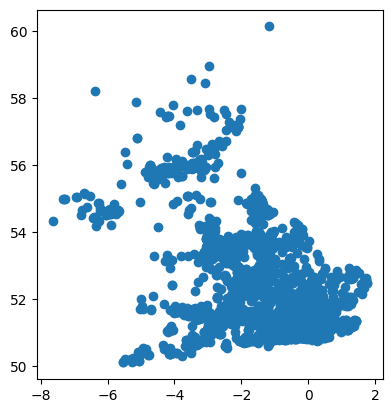

In [16]:
gdf.plot()

## Assign every non-tesco extra store to the nearest Tesco Extra

In [4]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

# DataFrames for different types of stores and one containing all stores
all = gdf
extra = gdf[gdf["Ordinal_type"] == 3].reset_index(drop=True)
other = gdf[gdf["Ordinal_type"] != 3].reset_index(drop=True)

# Create a list using geometry column to extract x and y coordinates
geometry_other = np.array(list(other.geometry.apply(lambda x: (x.x, x.y))))
geometry_extra = np.array(list(extra.geometry.apply(lambda x: (x.x, x.y))))

# Constructs a k-d tree using the coordinates provided in the geometry_extra list. Each row of geometry_extra is assumed to represent a point in a k-dimensional space.
btree = cKDTree(geometry_extra)

# Find the nearest neighbor (Tesco Extra) in terms of Euclidean distance for each point in geometry_other
dist, idx = btree.query(geometry_other, k=1)

nearest_extra = extra.iloc[idx].drop(columns="geometry").reset_index(drop=True)
df = pd.concat([other.reset_index(drop=True), nearest_extra, pd.Series(dist, name='dist')], axis=1)
df.head()

Name  Ordinal_type  Postcode   Latitude  \
0              Leavesden Green Express             1   WD5 0BT  51.700969   
1                  Aberdare Superstore             2  CF44 8DL  51.718031   
2      Union Street Castlegate Express             1  AB11 5BJ  57.147117   
3  Abergavenny Frogmore Street Express             1   NP7 5AH  51.824668   
4                  Abergele Superstore             2  LL22 7AA  53.285959   

   Longitude                   geometry                           Name  \
0  -0.403421  POINT (-0.40342 51.70097)                  Watford Extra   
1  -3.448706  POINT (-3.44871 51.71803)           Merthyr Tydfil Extra   
2  -2.096558  POINT (-2.09656 57.14712)                 Aberdeen Extra   
3  -3.020537  POINT (-3.02054 51.82467)                    Risca Extra   
4  -3.584931  POINT (-3.58493 53.28596)  Birkenhead Bidston Moss Extra   

   Ordinal_type  Postcode   Latitude  Longitude      dist  
0             3  WD17 2BD  51.651745  -0.387611  0.051701  
1             3  CF47 0AL  51.745623  -3.376865  0.076957  
2             3  AB22 8HB  57.179942  -2.145520  0.058947  
3             3  NP11 6NP  51.602204  -3.096926  0.235214  
4             3  CH43 7AA  53.408043  -3.070248  0.528964

In [18]:
#Rename columns
df.columns = ["other_name", "ordinal_type_other", "other_pc", "other_lat", "other_long", "geometry", "extra_name", "ordinal_type_extra", "extra_pc", "extra_lat", "extra_long", "dist"]

# Sort dataframe by tesco extra stores so we can have all stores who share the same tesco extra grouped together
df_sorted = df.sort_values(by="extra_pc").reset_index(drop=True)

# A check to see if the cell above has the same tesco extra store
df_sorted['check'] = df_sorted["extra_pc"].eq(df_sorted["extra_pc"].shift())

df_sorted.head()

other_name  ordinal_type_other  other_pc  other_lat  \
0                     Dyce Express                   1  AB21 0ET  57.203063   
1        Aberdeen South Superstore                   2  AB12 3DN  57.130266   
2  Union Street Castlegate Express                   1  AB11 5BJ  57.147117   
3      Aberdeen Woodend Superstore                   2  AB15 6LT  57.150464   
4         Aberdeen Grt Wst Express                   1  AB10 6PA  57.129843   

   other_long                   geometry      extra_name  ordinal_type_extra  \
0   -2.189070  POINT (-2.18907 57.20306)  Aberdeen Extra                   3   
1   -2.094124  POINT (-2.09412 57.13027)  Aberdeen Extra                   3   
2   -2.096558  POINT (-2.09656 57.14712)  Aberdeen Extra                   3   
3   -2.171099  POINT (-2.17110 57.15046)  Aberdeen Extra                   3   
4   -2.139280  POINT (-2.13928 57.12984)  Aberdeen Extra                   3   

   extra_pc  extra_lat  extra_long      dist  check  
0  AB22 8HB  57.179942    -2.14552  0.049307  False  
1  AB22 8HB  57.179942    -2.14552  0.071480   True  
2  AB22 8HB  57.179942    -2.14552  0.058947   True  
3  AB22 8HB  57.179942    -2.14552  0.039029   True  
4  AB22 8HB  57.179942    -2.14552  0.050487   True

## Using the above check assign a unique number to each group of stores which share the same Tesco Extra

In [22]:
polygon = []
n = 0
for x in df_sorted["check"]:
    if x == False:
        n += 1
    polygon.append(n)
df_sorted["polygon"] = polygon

In [23]:
df_sorted.head(19)

other_name  ordinal_type_other  other_pc  other_lat  \
0                      Dyce Express                   1  AB21 0ET  57.203063   
1         Aberdeen South Superstore                   2  AB12 3DN  57.130266   
2   Union Street Castlegate Express                   1  AB11 5BJ  57.147117   
3       Aberdeen Woodend Superstore                   2  AB15 6LT  57.150464   
4          Aberdeen Grt Wst Express                   1  AB10 6PA  57.129843   
5         Aberdeen Union St Express                   1  AB11 6DB  57.142894   
6                  Ellon Superstore                   2  AB41 9RY  57.367854   
7            Pittodrie Esso Express                   1  AB24 3DF  57.161597   
8    Aberdeen Newtonhill Superstore                   2  AB39 3PX  57.031231   
9       Aberdeen North Dees Express                   1  AB15 9SX  57.117225   
10        Great Northern Rd Express                   1  AB24 2AX  57.170723   
11      Aberdeen Holburn St Express                   1  AB10 6BL  57.138033   
12           Fraserburgh Superstore                   2  AB43 9TE  57.679605   
13              Westhill Superstore                   2  AB32 6UF  57.149512   
14               Turriff Superstore                   2  AB53 4EN  57.537270   
15               Lerwick Superstore                   2   ZE1 0RD  60.147131   
16                Huntly Superstore                   2  AB54 8TS  57.448572   
17                 Banff Superstore                   2  AB45 1AF  57.664859   
18              Banchory Superstore                   2  AB31 5QA  57.060282   

    other_long                   geometry                 extra_name  \
0    -2.189070  POINT (-2.18907 57.20306)             Aberdeen Extra   
1    -2.094124  POINT (-2.09412 57.13027)             Aberdeen Extra   
2    -2.096558  POINT (-2.09656 57.14712)             Aberdeen Extra   
3    -2.171099  POINT (-2.17110 57.15046)             Aberdeen Extra   
4    -2.139280  POINT (-2.13928 57.12984)             Aberdeen Extra   
5    -2.111409  POINT (-2.11141 57.14289)             Aberdeen Extra   
6    -2.044658  POINT (-2.04466 57.36785)             Aberdeen Extra   
7    -2.096272  POINT (-2.09627 57.16160)             Aberdeen Extra   
8    -2.158245  POINT (-2.15824 57.03123)             Aberdeen Extra   
9    -2.177451  POINT (-2.17745 57.11722)             Aberdeen Extra   
10   -2.124052  POINT (-2.12405 57.17072)             Aberdeen Extra   
11   -2.114044  POINT (-2.11404 57.13803)             Aberdeen Extra   
12   -2.003857  POINT (-2.00386 57.67960)             Aberdeen Extra   
13   -2.275516  POINT (-2.27552 57.14951)             Aberdeen Extra   
14   -2.463130  POINT (-2.46313 57.53727)  Inverurie Harlaw Rd Extra   
15   -1.161252  POINT (-1.16125 60.14713)  Inverurie Harlaw Rd Extra   
16   -2.803583  POINT (-2.80358 57.44857)  Inverurie Harlaw Rd Extra   
17   -2.519882  POINT (-2.51988 57.66486)  Inverurie Harlaw Rd Extra   
18   -2.466434  POINT (-2.46643 57.06028)  Inverurie Harlaw Rd Extra   

    ordinal_type_extra  extra_pc  extra_lat  extra_long      dist  check  \
0                    3  AB22 8HB  57.179942   -2.145520  0.049307  False   
1                    3  AB22 8HB  57.179942   -2.145520  0.071480   True   
2                    3  AB22 8HB  57.179942   -2.145520  0.058947   True   
3                    3  AB22 8HB  57.179942   -2.145520  0.039029   True   
4                    3  AB22 8HB  57.179942   -2.145520  0.050487   True   
5                    3  AB22 8HB  57.179942   -2.145520  0.050360   True   
6                    3  AB22 8HB  57.179942   -2.145520  0.213270   True   
7                    3  AB22 8HB  57.179942   -2.145520  0.052554   True   
8                    3  AB22 8HB  57.179942   -2.145520  0.149254   True   
9                    3  AB22 8HB  57.179942   -2.145520  0.070377   True   
10                   3  AB22 8HB  57.179942   -2.145520  0.023364   True   
11                   3  AB22 8HB  57.179942   -2.145520  0.052413   Tru

In [7]:
just_extra = df_sorted[['ordinal_type_other','ordinal_type_extra', 'extra_name', 'extra_pc', 'extra_lat','extra_long', 'polygon', "geometry", "check", "dist"]]
just_extra = just_extra.drop_duplicates(subset=["extra_pc"], keep="first").reset_index(drop=True)

In [8]:
# Creating new columns in preparation for the join
just_extra["other_name"] = just_extra["extra_name"]
just_extra["other_pc"] = just_extra["extra_pc"]
just_extra["other_lat"] = just_extra["extra_lat"]
just_extra["other_long"] = just_extra["extra_long"]
just_extra["ordinal_type_other"] = "3"

In [9]:
just_extra = just_extra[['ordinal_type_other', 'other_name', 'other_pc', 'other_lat', 'other_long', 'geometry',
       'ordinal_type_extra', 'extra_name', 'extra_pc', 'extra_lat', 'extra_long', 'dist',
       'check', 'polygon']]
just_extra.head()

ordinal_type_other                 other_name  other_pc  other_lat  \
0                  3             Aberdeen Extra  AB22 8HB  57.179942   
1                  3  Inverurie Harlaw Rd Extra  AB51 4SR  57.287562   
2                  3             Hatfield Extra   AL9 5JY  51.776321   
3                  3              Yardley Extra   B26 1AD  52.462359   
4                  3        Cradley Heath Extra   B64 5DF  52.473075   

   other_long                   geometry  ordinal_type_extra  \
0   -2.145520  POINT (-2.18907 57.20306)                   3   
1   -2.376527  POINT (-2.46313 57.53727)                   3   
2   -0.220396  POINT (-0.21511 51.83063)                   3   
3   -1.813408  POINT (-1.78511 52.44263)                   3   
4   -2.081238  POINT (-2.04951 52.45951)                   3   

                  extra_name  extra_pc  extra_lat  extra_long      dist  \
0             Aberdeen Extra  AB22 8HB  57.179942   -2.145520  0.049307   
1  Inverurie Harlaw Rd Extra  AB51 4SR  57.287562   -2.376527  0.264300   
2             Hatfield Extra   AL9 5JY  51.776321   -0.220396  0.054565   
3              Yardley Extra   B26 1AD  52.462359   -1.813408  0.034492   
4        Cradley Heath Extra   B64 5DF  52.473075   -2.081238  0.034509   

   check  polygon  
0  False        1  
1  False        2  
2  False        3  
3  False        4  
4  False        5

## Join both datasets together

In [10]:
tesco_stores = pd.concat([df_sorted, just_extra])
tesco_stores[["ordinal_type_other"]] = tesco_stores[["ordinal_type_other"]].astype(int)
tesco_stores = tesco_stores.sort_values(by=["polygon", "ordinal_type_other"], ascending = [True, False]).reset_index(drop=True)

In [11]:
tesco_stores

other_name  ordinal_type_other  other_pc  other_lat  \
0                     Aberdeen Extra                   3  AB22 8HB  57.179942   
1          Aberdeen South Superstore                   2  AB12 3DN  57.130266   
2        Aberdeen Woodend Superstore                   2  AB15 6LT  57.150464   
3                   Ellon Superstore                   2  AB41 9RY  57.367854   
4     Aberdeen Newtonhill Superstore                   2  AB39 3PX  57.031231   
...                              ...                 ...       ...        ...   
2822         Piccadilly York Express                   1   YO1 9TU  53.957008   
2823               Strensall Express                   1  YO32 5XR  54.039948   
2824          Gillygate York Express                   1  YO31 7EA  53.964230   
2825       York Low Ousegate Express                   1   YO1 9QX  53.957500   
2826        York Goodramgate Express                   1   YO1 7LS  53.960708   

      other_long                   geometry      extra_name  \
0      -2.145520  POINT (-2.18907 57.20306)  Aberdeen Extra   
1      -2.094124  POINT (-2.09412 57.13027)  Aberdeen Extra   
2      -2.171099  POINT (-2.17110 57.15046)  Aberdeen Extra   
3      -2.044658  POINT (-2.04466 57.36785)  Aberdeen Extra   
4      -2.158245  POINT (-2.15824 57.03123)  Aberdeen Extra   
...          ...                        ...             ...   
2822   -1.078487  POINT (-1.07849 53.95701)      York Extra   
2823   -1.034412  POINT (-1.03441 54.03995)      York Extra   
2824   -1.084310  POINT (-1.08431 53.96423)      York Extra   
2825   -1.082713  POINT (-1.08271 53.95750)      York Extra   
2826   -1.079859  POINT (-1.07986 53.96071)      York Extra   

      ordinal_type_extra  extra_pc  extra_lat  extra_long      dist  check  \
0                      3  AB22 8HB  57.179942   -2.145520  0.049307  False   
1                      3  AB22 8HB  57.179942   -2.145520  0.071480   True   
2                      3  AB22 8HB  57.179942   -2.145520  0.039029   True   
3                      3  AB22 8HB  57.179942   -2.145520  0.213270   True   
4                      3  AB22 8HB  57.179942   -2.145520  0.149254   True   
...                  ...       ...        ...         ...       ...    ...   
2822                   3  YO30 4XZ  53.991178   -1.104219  0.042775   True   
2823                   3  YO30 4XZ  53.991178   -1.104219  0.085156   True   
2824                   3  YO30 4XZ  53.991178   -1.104219  0.033505   True   
2825                   3  YO30 4XZ  53.991178   -1.104219  0.039959   True   
2826                   3  YO30 4XZ  53.991178   -1.104219  0.039011   True   

      polygon  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
2822      252  
2823      252  
2824      252  
2825      252  
2826      252  

[2827 rows x 14 columns]

## Remove unwanted columns and rename some columns

In [12]:
tesco_stores = tesco_stores[['ordinal_type_other', 'other_name', 'other_pc', 'other_lat', 'other_long', 'geometry', 'polygon']]
tesco_stores = tesco_stores.rename(columns={"ordinal_type_other": "ordinal_type", 'other_name':'store_name', "other_pc": "post_code", "other_lat": "latitude", "other_long": "longitude"})

In [13]:
tesco_stores.head()

ordinal_type                      store_name post_code   latitude  \
0             3                  Aberdeen Extra  AB22 8HB  57.179942   
1             2       Aberdeen South Superstore  AB12 3DN  57.130266   
2             2     Aberdeen Woodend Superstore  AB15 6LT  57.150464   
3             2                Ellon Superstore  AB41 9RY  57.367854   
4             2  Aberdeen Newtonhill Superstore  AB39 3PX  57.031231   

   longitude                   geometry  polygon  
0  -2.145520  POINT (-2.18907 57.20306)        1  
1  -2.094124  POINT (-2.09412 57.13027)        1  
2  -2.171099  POINT (-2.17110 57.15046)        1  
3  -2.044658  POINT (-2.04466 57.36785)        1  
4  -2.158245  POINT (-2.15824 57.03123)        1

In [14]:
tesco_stores[["latitude","longitude"]] = tesco_stores[["latitude","longitude"]].astype(float)

## Plot polygons onto a map

In [24]:
import random
from scipy.spatial import ConvexHull

# Function to draw points in the map
def draw_points(map_object, tesco_stores, list_of_points, layer_name, line_color, fill_color):

    fg = folium.FeatureGroup(name=layer_name)

    for name, lat, long in list_of_points:
        fg.add_child(folium.CircleMarker((lat, long), radius=3, color=line_color, fill_color=fill_color, popup=(folium.Popup(name))))
    
    map_object.add_child(fg)

# Function that takes a map and a list of points (LON,LAT tupels) and
# returns a map with the convex hull polygon from the points as a new layer

def create_convexhull_polygon(map_object, list_of_points, layer_name, line_color, fill_color, weight): 

    # Since it is pointless to draw a convex hull polygon around less than 3 points check len of input
    if len(list_of_points) < 3:
        return

    # Create the convex hull using scipy.spatial 
    form = [list_of_points[i] for i in ConvexHull(list_of_points).vertices]

    # Add the polygons to the
    fg = folium.FeatureGroup(name=layer_name)
    fg.add_child(folium.vector_layers.Polygon(locations=form, color=line_color, fill_color=fill_color, weight=weight))
    map_object.add_child(fg)

    return(map_object)

#Same as above but got rid of layer control
def create_grouped_convexhulls(map_object, tesco_stores, layer_name, line_color, fill_color, weight):
    for label, group in tesco_stores.groupby('polygon'):
        points = group[["latitude", "longitude"]].values.tolist()
        create_convexhull_polygon(map_object, points, layer_name=layer_name, line_color=line_color, fill_color=fill_color, weight=weight)

# Initialize map
my_convexhull_map = folium.Map(location=[55, -2], zoom_start=6)

points = tesco_stores[["latitude", "longitude"]].values.tolist()
list_of_points = points

#dataframe with only tesco extra
just_extra = tesco_stores[tesco_stores["ordinal_type"] == 3].reset_index(drop=True)
just_extra_points = just_extra[["store_name", "latitude", "longitude"]].values.tolist()

#dataframe with non-extra stores
non_extra = tesco_stores[tesco_stores["ordinal_type"] != 3].reset_index(drop=True)
non_extra_points = non_extra[["store_name", "latitude", "longitude"]].values.tolist()

# Create convex hulls for each group
create_grouped_convexhulls(my_convexhull_map, tesco_stores, layer_name='Polygons', line_color='skyblue', fill_color='lightskyblue', weight=10)

# Add non-tesco extra store points as markers
draw_points(my_convexhull_map, tesco_stores, non_extra_points, layer_name='Non-Extra stores', line_color='#7289da', fill_color='royalblue')

# Add tesco extra store points as markers
draw_points(my_convexhull_map, tesco_stores, just_extra_points, layer_name='Extra stores', line_color='#063970', fill_color='royalblue')

# Add layer control and show map
folium.LayerControl(collapsed=False).add_to(my_convexhull_map)
#my_convexhull_map.save('map.html')
my_convexhull_map